# 02 - Recurso energético disponible

Se realiza el cálculo del recurso solar energético disponible según los datos proporcionados de irradiancia solar. El cálculo de este recurso se realiza utilizando un modelo físico de proyección de irradiancia en un plano generalizado. Posteriormente esta información se traduce a energía disponible por metro cuadrado.

In [1]:
import matplotlib.pyplot as plt

In [2]:
# Crear dataframe con los sets de datos de NREL
import nrel_system.parse_nrel as parse_nrel

merida = [
    "data/mx-merida/2018.csv",
    "data/mx-merida/2019.csv",
    "data/mx-merida/2020.csv"
]

nrel, L = parse_nrel.main(merida)

In [3]:
# Calcular (e inyectar) variables de temporales, de geometría solar y valores de irradiancia por componentes difusa y directa
import physical_system.setup_variables as setup_variables

nrel = setup_variables.main(nrel,L)

def print_cols(df):
    cols = '|'
    for c in df.columns:
        cols = cols + c + '|'
    print('Columns: ' + cols)
    
print_cols(nrel)

Columns: |YEAR|MONTH|DAY|HOUR|MINUTE|MINS_SINCE_EQUINOX|TEMPERATURE|DNI|DHI|GHI|GI|X_DIF|X_DIR|Z|D|H|A|ALPHA|


## Irradiancia proyectada (I_PROJ)

Procedemos a realizar un análisis descriptivo de las cantidades de irradiancia proyectada en el tiempo según los sets de datos estudiados. Con esto se pretende entender mejor la forma en que las variables geométricas del sistema físico descrito influyen en la disponibilidad del recurso energético disponible para una determinada instalación de paneles solares que toma en cuenta dichas variables.

**_VARIABLES DE PROYECCIÓN SOLAR EN PLANO GENERALIZADO_**
- **B**: Ángulo acimutal del vector normal al plano. Para el caso de paneles solares con orientación estática a lo largo del año, el ángulo acimutal de mayor disponibilidad de recurso energético es igual a cero, osea que vector normal del plano generalizado estaría apuntando al sur en todo momento.
- **BETA**: Ángulo de inclinación del plano. Definido como el ángulo entre el plano del observador y el plano de proyección. También conocido como ángulo de inclinación de los paneles solares. Se eligen los valor de inclinación de 18º, 24º, y 30º de forma arbitaria con propósitos demostrativos, con la particularidad de ser valores verosímiles en cuanto a una instalación de paneles para la locaciones dentro de México.
- **I_PROJ**: Irradiancia proyectada en el plano parametrizado por __B__ y __BETA__

In [4]:
# Realizar cálculo de proyección de irradiancia en plano generalizado utilizando como parámetros de plano 
#     el ángulo acimutal solar y el ángulo de inclinación planar
import projection_system.setup_projection as setup_projection

def project_nrel(nrel,BETA,B=0):
    # Definimos el set de columnas de interés para el presente análisis de recurso energético
    cols = ['YEAR','MONTH','DAY','HOUR','MINUTE','TEMPERATURE','A','ALPHA','BETA','I_PROJ']
    return setup_projection.main(nrel,B,BETA=BETA)[cols]

De especial interés para nosotros es la irradiancia proyectada en el plano generalizado que hemos parametrizado en el paso anterior. Utilizando este dato podemos realizar un análisis energético histórico para los sets de datos utilizados y calcular la cantidad de energía disponible durante los periodos comprendidos por los mismos.

### Diferentes ángulos, misma fecha

A continuación realizamos una comparación de las cantidades de irradiancia proyectada para dos diferentes ángulos de inclinación. Esto nos permite visualizar la relevancia de analizar y elegir el ángulo óptimo para obtener la mayor producción de energía posible.

In [5]:
def compare_angles_by_date(YEAR,MONTH,DAY,BETA_LIST):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    fig.set_dpi(100)
    plt.margins(x=0)
    for BETA in BETA_LIST:
        nrel_BETA = project_nrel(nrel,BETA)
        I_PROJ = nrel_BETA.loc[(nrel_BETA.YEAR == YEAR)&(nrel_BETA.MONTH==MONTH)&(nrel_BETA.DAY==DAY)]
        plt.plot(I_PROJ.index,I_PROJ.I_PROJ,label='BETA = ' + str(BETA)+'º',alpha=0.6)
        plt.axhline(y=I_PROJ.I_PROJ.max(), color='m',linestyle='-.',linewidth=0.5)
    ticks = I_PROJ.loc[(I_PROJ.MINUTE==0)]
    plt.xticks(ticks.index,ticks.HOUR)
    plt.legend()
    plt.grid(True)
    plt.title('Projected irradiance of date: '+str(YEAR)+'-'+str(MONTH)+'-'+str(DAY))
    plt.ylabel('I_PROJ [W/m^2]')
    plt.xlabel('Hour of the day')
    plt.show()

# Graficar la irradiancia proyectada para un día en específico pero con diferentes ángulos de inclinación
YEAR = 2020
DAY = 21
BETA_LIST = [20,40,60] # Calcularemos la irradiancia proyectada para cada elemento de esta lista

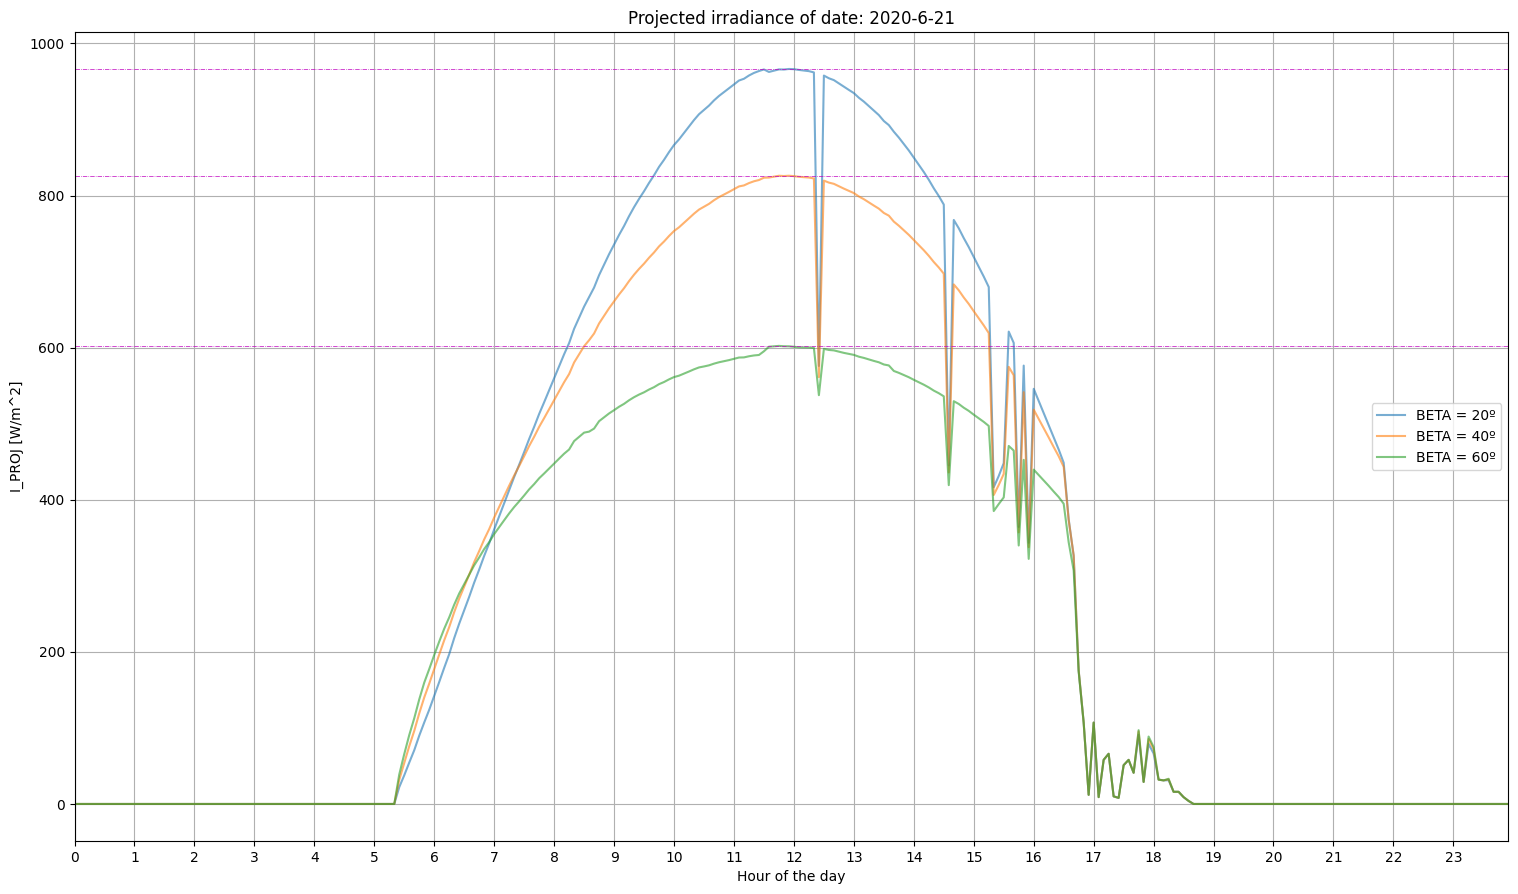

In [6]:
MONTH = 6
compare_angles_by_date(YEAR,MONTH,DAY,BETA_LIST)

La gráfica de irradiancia proyectada para tres ángulos diferentes al 21 de junio tiene varias características interesantes a mencionar. 

Nótese que en el punto de irradiancia proyectada máxima a medio día es menor para la curva de 60º que para la de 20º. Sin embargo, esto es diferente al inicio del día desde poco después de las 5 hasta poco después de las 7 de la mañana. Esto sucede porque diferentes ángulos de inclinación captaran diferentes cantidades de irradiancia proyectada según el ángulo de altura solar que va tomando diferentes valores a lo largo del día, tomando su valor máximo al medio día.

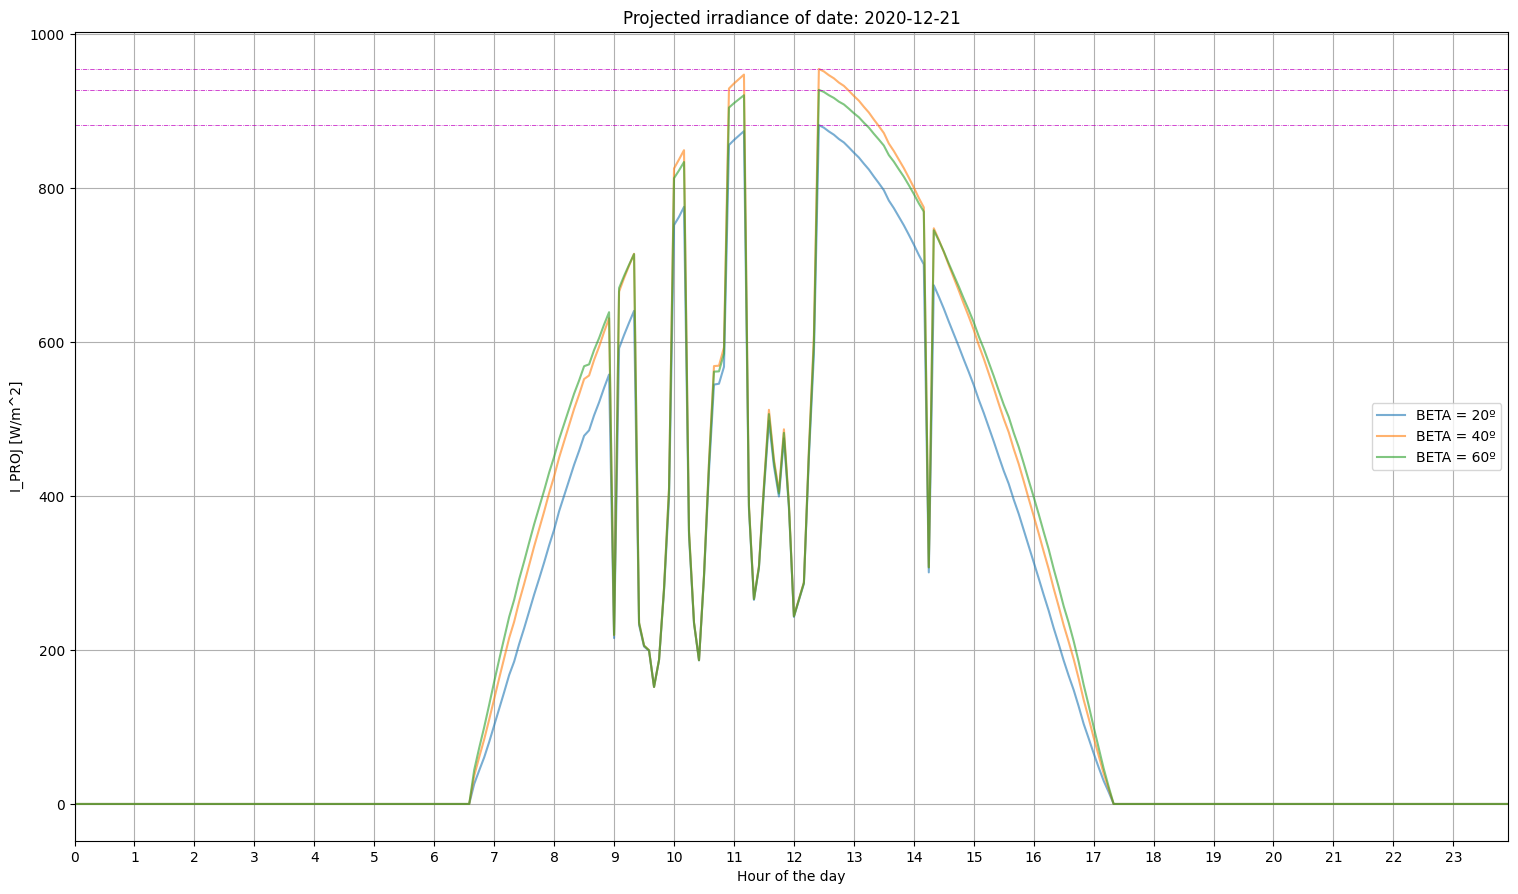

In [7]:
MONTH = 12
compare_angles_by_date(YEAR,MONTH,DAY,BETA_LIST)

Nótese que en el caso del 8 de diciembre el ángulo preferente para la captación de irradiancia máxima al medio día es de 40º, a diferencia del caso anterior estudiado donde el ángulo preferente era de 60º. Esto nos muestra que tanto el ángulo de altura solar como la geometría planetaria junto con los movimientos de traslación influyen en la cantidad de irradiancia proyectada a lo largo del año para un ángulo fijo.

Este dato es relevante para entender cuál será el ángulo de inclinación óptimo de los paneles solares en caso de decidir mantenerlo fijo durante todo el año; o también sería relevante para entender los ángulos de inclinación óptimos para determinados periodos en el año, ya sea que se trate de dos periodos de seis meses o un mayor número de periodos.

### Diferentes fechas, un mismo ángulo

Ahora realizamos una comparación similar pero esta vez lo hacemos para los años disponibles en los datos, utilizando un ángulo de inclinación BETA fijo a 24º y haciendo la comparación para dos días separados por seis meses.

In [8]:
def compare_dates_by_angle(BETA,MONTH,DAY,YEAR_LIST):
    nrel_BETA = project_nrel(nrel,BETA)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    fig.set_dpi(100)
    plt.margins(x=0)
    for YEAR in YEAR_LIST:
        I_PROJ = nrel_BETA.loc[(nrel_BETA.YEAR == YEAR)&(nrel_BETA.MONTH==MONTH)&(nrel_BETA.DAY==DAY)].reset_index()
        plt.plot(I_PROJ.index,I_PROJ.I_PROJ,label=str(YEAR)+'-'+str(MONTH).zfill(2)+'-'+str(DAY).zfill(2),alpha=0.6)
        plt.axhline(y=I_PROJ.I_PROJ.max(), color='m',linestyle='-.',linewidth=0.5)
    ticks = I_PROJ.loc[(I_PROJ.MINUTE==0)]
    plt.xticks(ticks.index,ticks.HOUR)
    plt.legend()
    plt.grid(True)
    plt.title('Projected irradiance for inclination BETA = '+str(BETA)+'º')
    plt.ylabel('I_PROJ [W/m^2]')
    plt.xlabel('Hour of the day')
    plt.show()

BETA = 24
DAY = 8

YEAR_LIST = [2018,2019,2020] # Calcularemos la irradiancia proyectada para cada elemento de esta lista

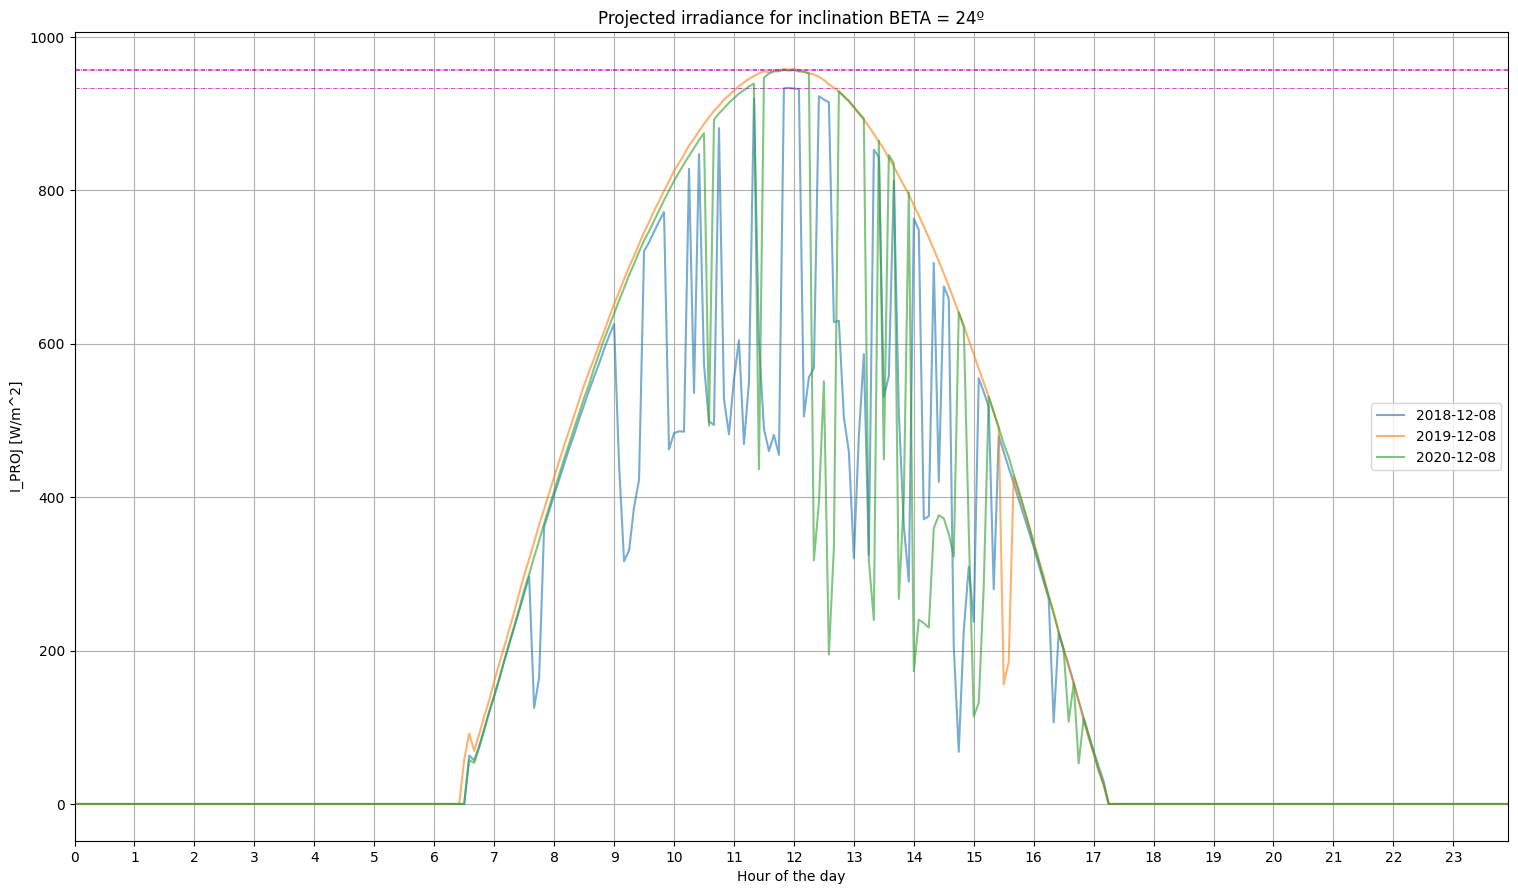

In [9]:
MONTH = 12
compare_dates_by_angle(BETA,MONTH,DAY,YEAR_LIST)

Esta comparación nos ayuda a comprender que existe una irradiancia proyectada similar para la misma fecha en diferentes años, esto gracias a la naturaleza cíclica del movimiento traslacional de nuestro planeta en el sistema solar. Aunque el modelo físico utilizado toma en cuenta cuerpos en movimiento mecánico idealizado, la realidad es que el cuerpo planetario de la tierra posee imperfecciones que aunque se aproximen a la forma de una esfera, puede inducir este tipo de discrepancias en el estudio ciclíco de la irradiancia.

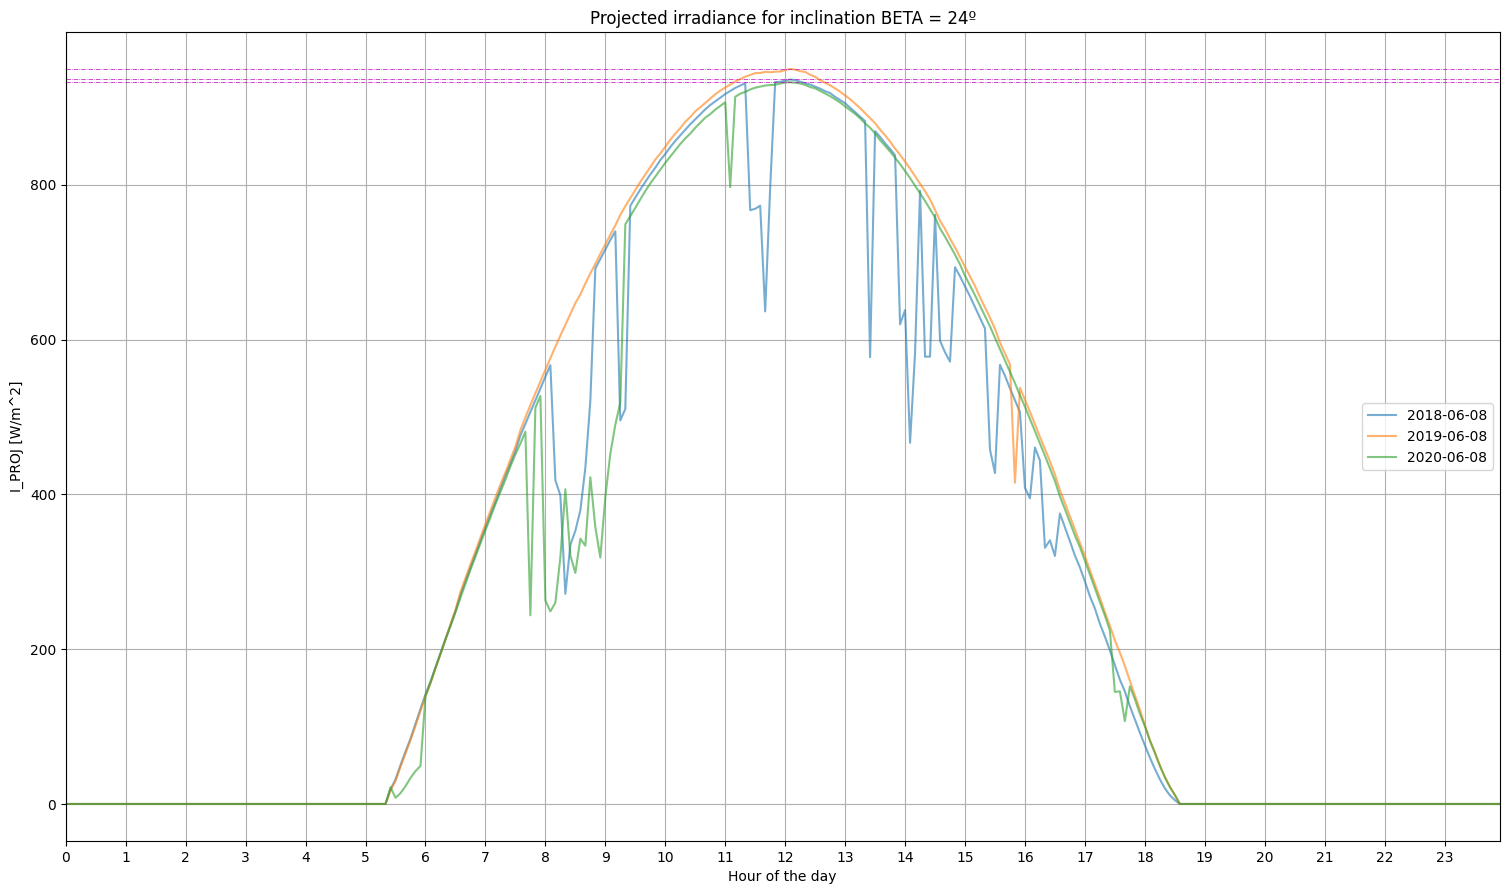

In [10]:
MONTH = 6
compare_dates_by_angle(BETA,MONTH,DAY,YEAR_LIST)

Realizamos una segunda comparación con una separación de 6 meses con respecto a la comparación realizada previamente. Llegamos a la misma conclusión de que existen imperfecciones en la formulación de nuestro modelo físico dadas las geometrías ideales planteadas que se ajustan a los datos estudiados solamente de forma aproximada, pero con un grado de similitud satisfactorio.

## Conclusión

Hemos realizado un análisis descriptivo de la irradiancia proyectada en un plano generalizado y hemos observado que existen discrepancias entre los datos estudiados y el modelo físico planteado para la indagación de la disponibilidad del recurso solar en Mérida. 

Con esto confirmamos que nuestro modelo físico es solamente una aproximación a la realidad caótica de los sistemas planetarios involucrados. Gracias a los datos que tenemos a nuestra disposición podremos realizar una estimación de la energía eléctrica que podría ser generada en un futuro con la intención de minimizar el error de cálculo que el uso de un modelo físico de cuerpos y geometrías ideales generaría.